In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sn
from scipy.stats import t
from scipy import stats
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale


Observation about filename: It wasn't specified what to do if we had more than one last name. Unfortunately I have three, so I took the liberty of tranforming the spaces into _ despite partially violating the naming conventions. My last name is: "Souza Pinto Medeiros". So I thought it would be better to name this file the way I did rather than "sd-tsia204_lab2_souza pinto medeiros_gabriel" in order to avoid using spaces.

### 1.

In [2]:
# Importing the data
filename = 'data_tp_2.csv'
df = pd.read_csv(filename, sep=',', nrows=20000000)


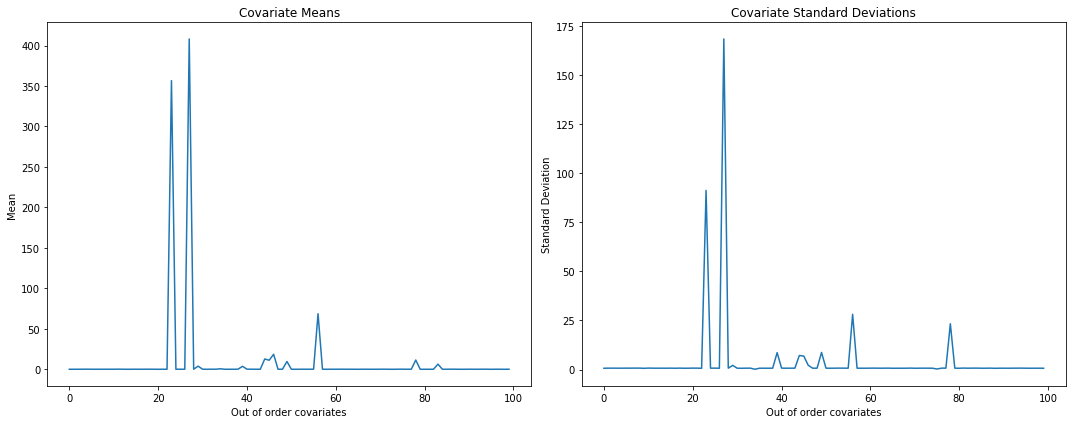

Y has a mean of: 22.53
Y has a standard deviation of: 9.20


In [3]:
mean = df.mean()[:-1]
std = df.std()[:-1]

plt.subplots(1, 2, figsize=(15, 6))

# Plotting the means
plt.subplot(121)
plt.plot(range(len(mean)), mean)
plt.title('Covariate Means')
plt.ylabel('Mean')
plt.xlabel('Out of order covariates')

# Plotting the standard deviations
plt.subplot(122)
plt.plot(range(len(std)), std)
plt.title('Covariate Standard Deviations')
plt.ylabel('Standard Deviation')
plt.xlabel('Out of order covariates')

plt.tight_layout()
plt.show()

print(f'Y has a mean of: {df.mean()[-1]:.2f}')
print(f'Y has a standard deviation of: {df.std()[-1]:.2f}')



The plots show that certain covariates and Y aren't standardized.

In [4]:
# Separating matrixes X and Y
Y = df.loc[:, 'Y']
X = df.loc[:, 'X76':'X96']

X_labels = X.columns


In [5]:
# Separating our dataset into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,
                                                    random_state=0)

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


In [6]:
# Scaling
scalerX = StandardScaler()

# Fitting to train data
scalerX.fit(X_train)

# Scaling both train and test to train
# Y was normalized because on page 29 of this course's poly it says that in order
# to perform a PCA analysis both X and Y must be centered. Therefore, to get 
# comparable results I used normalized Y for all regressions
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
Y_train = (Y_train - Y_train.mean())/Y_train.std()
Y_test = (Y_test - Y_test.mean())/Y_test.std()


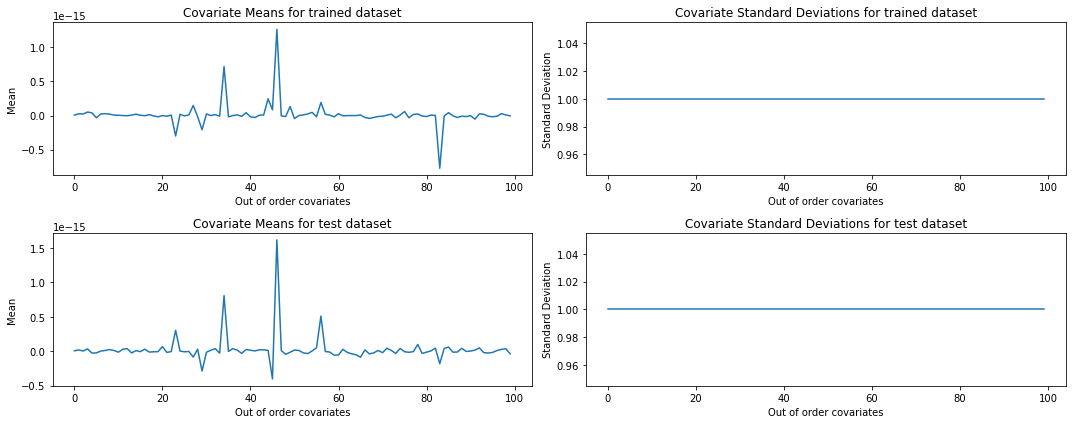

In [7]:
# Getting the means and standard deviations in order to plot them
mean_train = X_train.mean(0)
std_train = X_train.std(0)
mean_test = X_test.mean(0)
std_test = X_test.std(0)

plt.subplots(2, 2, figsize=(15, 6))

# Plotting the means for the trained dataset
plt.subplot(221)
plt.plot(range(len(mean_train)), mean_train)
plt.title('Covariate Means for trained dataset')
plt.ylabel('Mean')
plt.xlabel('Out of order covariates')

# Plotting the standard deviations for the trained dataset
plt.subplot(222)
plt.plot(range(len(std_train)), std_train)
plt.title('Covariate Standard Deviations for trained dataset')
plt.ylabel('Standard Deviation')
plt.xlabel('Out of order covariates')

# Plotting the means for the test dataset
plt.subplot(223)
plt.plot(range(len(mean_test)), mean_test)
plt.title('Covariate Means for test dataset')
plt.ylabel('Mean')
plt.xlabel('Out of order covariates')

# Plotting the standard deviations for the test dataset
plt.subplot(224)
plt.plot(range(len(std_test)), std_test)
plt.title('Covariate Standard Deviations for test dataset')
plt.ylabel('Standard Deviation')
plt.xlabel('Out of order covariates')

plt.tight_layout()
plt.show()


It is important to eliminate the y-intercept from the model. In the Lasso and ridge models, it is expected that both Y and X have empirical mean 0 for it to work so centering both Y and X is crucial. Also, the absence of an intercept is a prerequisite for applying the PCA before the OLS.

In [8]:
df_test = pd.DataFrame()
df_coef = pd.DataFrame()


### 2.

In [9]:
# Obtains the determination coefficient
def determination_coefficient(Y, f):
    mean = Y.mean()
    sst = (Y-mean)@(Y-mean).T
    ssr = (Y - f)@(Y - f).T 
    return 1 - ssr/sst

# Obtains the mean squared error
def mean_squared_error(Y, f):
    e = Y - f
    return (e@e.T)/len(Y)


### 3.

In [10]:
# Importing the linear regression and saving useful values
reg = LinearRegression().fit(X_train, Y_train)
df_coef.loc[:, 'OLS'] = reg.coef_
df_test.loc[:, 'OLS'] = np.array(reg.predict(X_test))


In [12]:
np.shape(X_train)

(379, 100)

In [13]:
np.shape(Y_train)

(379,)

In [429]:
# Obtaining and printing R2 and MSE
dc = determination_coefficient(Y_test, np.array(df_test.loc[:, 'OLS']))
mse = mean_squared_error(Y_test, np.array(df_test.loc[:, 'OLS']))
print(f'The determination coefficient obtained was: {dc:.3f}')
print(f'The mean squared error obtained was: {mse:.3f}')


The determination coefficient obtained was: 0.546
The mean squared error obtained was: 0.454


### 4.

In [430]:
# Calculating the covariance matrix
cov_matrix = np.cov(X_train.T)


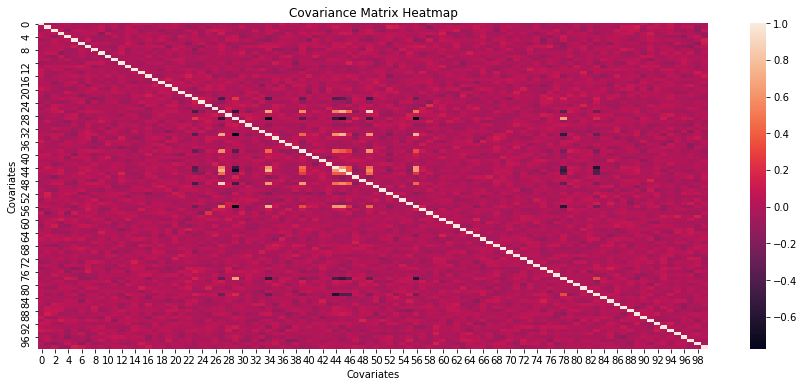

In [431]:
# Plotting the covariance matrix
plt.figure(figsize=(15, 6))
sn.heatmap(cov_matrix)
plt.title('Covariance Matrix Heatmap')
plt.xlabel('Covariates')
plt.ylabel('Covariates')
plt.show()


In [432]:
# Doing the SVD decomposition
U, s, V = np.linalg.svd(cov_matrix)

### 5.

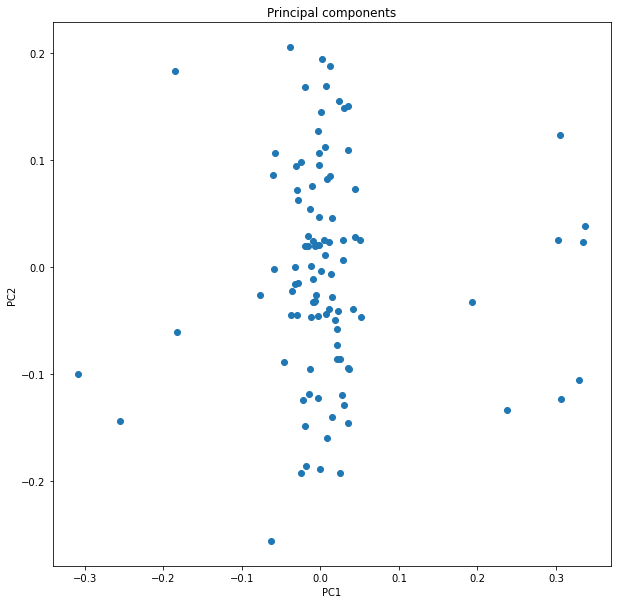

In [433]:
# Plotting the principal components
plt.figure(figsize=(10, 10))
plt.scatter(U[:, 0], U[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal components')
plt.show()


### 6.

In [434]:
# Obtaining the pca features for 2 PC
pca_train = X_train@U[:, :2]
pca_test = X_test@U[:, :2]


In [435]:
# Fitting the PCA OLS and saving interesting values
reg_pca = LinearRegression().fit(pca_train, Y_train)
df_test.loc[:, 'pca_ols'] = np.array(reg_pca.predict(pca_test))


In [436]:
# Obtaining and printing R2 and MSE
dc = determination_coefficient(Y_test, np.array(df_test.loc[:, 'pca_ols']))
mse = mean_squared_error(Y_test, np.array(df_test.loc[:, 'pca_ols']))
print(f'The determination coefficient obtained was: {dc:.3f}')
print(f'The mean squared error obtained was: {mse:.3f}')


The determination coefficient obtained was: 0.219
The mean squared error obtained was: 0.781


### 7.

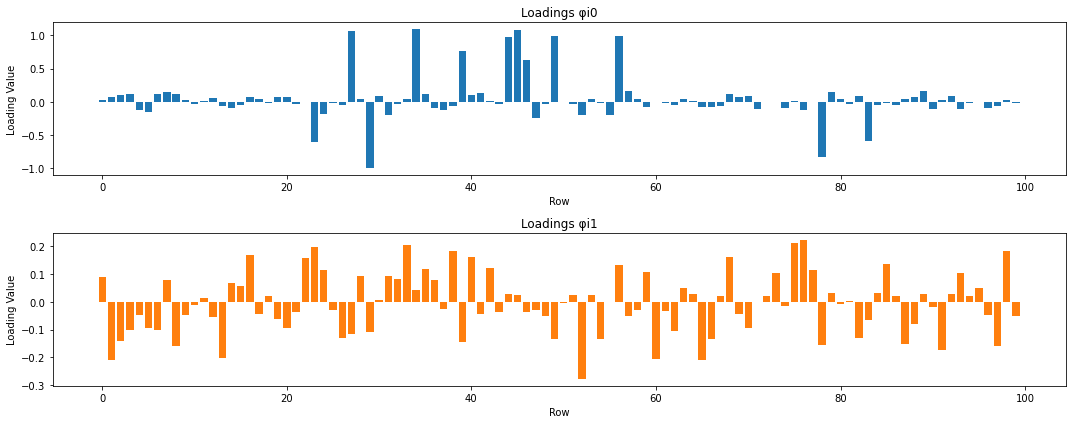

In [437]:
# Plotting PCA loadings
plt.subplots(2, 1, figsize=(15, 6))

plt.subplot(211)
plt.bar(range(np.shape(U[:, 0])[0]), U[:, 0]*s[0]**1/2)
plt.xlabel('Row')
plt.ylabel('Loading Value')
plt.title('Loadings φi0')

plt.subplot(212)
plt.bar(range(np.shape(U[:, 1])[0]), U[:, 1]*s[1]**1/2, color = 'C1')
plt.xlabel('Row')
plt.ylabel('Loading Value')
plt.title('Loadings φi1')

plt.tight_layout()
plt.show()


### 8.

In [438]:
# Importing and fitting the Lasso
alphas = np.logspace(np.log10(10e-3), np.log10(10e-1), num=30)
las = LassoCV(alphas=alphas).fit(X_train, Y_train)


In [439]:
# Saving useful values
df_test.loc[:, 'lasso'] = las.predict(X_test)
df_coef.loc[:, 'lasso'] = las.coef_


In [440]:
# Obtaining and printing R2 and MSE
dc = determination_coefficient(Y_test, np.array(df_test.loc[:, 'lasso']))
mse = mean_squared_error(Y_test, np.array(df_test.loc[:, 'lasso']))
print(f'The determination coefficient obtained was: {dc:.3f}')
print(f'The mean squared error obtained was: {mse:.3f}')


The determination coefficient obtained was: 0.580
The mean squared error obtained was: 0.420


### 9.

In [461]:
# Importing and fitting the ridge
alphas = np.logspace(np.log10(10e-1), np.log10(10e2), num=30)
rid = RidgeCV(alphas=alphas).fit(X_train, Y_train)


In [462]:
# Saving useful values
df_test.loc[:, 'ridge'] = rid.predict(X_test)
df_coef.loc[:, 'ridge'] = rid.coef_


In [463]:
# Obtaining and printing R2 and MSE
dc = determination_coefficient(Y_test, np.array(df_test.loc[:, 'ridge']))
mse = mean_squared_error(Y_test, np.array(df_test.loc[:, 'ridge']))
print(f'The determination coefficient obtained was: {dc:.3f}')
print(f'The mean squared error obtained was: {mse:.3f}')


The determination coefficient obtained was: 0.539
The mean squared error obtained was: 0.461


### 10.

In [486]:
#Initializing values for the FVS
r = Y_train
S = []
A = list(range(100))
pval = list(range(100))


In [487]:
# Obtains the unidimensional regression's coefficient
def coef(X, r):
    return LinearRegression().fit(X.reshape(-1, 1), r).coef_

# Calculates the s function for the T-value
def s(X):
    return (X.T@X/len(X))**(-1/2)

# Calculates the square root of the noise level
def sig(X, r):
    return np.linalg.norm(r - coef(X, r)*X)/(len(X)-2)**(1/2)

# Calculates the Tstat for a single Xk
def T(X, r):
    return (np.abs(coef(X, r))/(s(X)*sig(X, r)))[0]*len(X)**(1/2)

# Returns a list containing all T values for a given set of features
# A contains the set of usable indexes
def TList(A, X, r):
    arr = np.zeros(100)
    for i in A:
        arr[i] = T(X[:, i], r)
    return arr


In [488]:
# Performs FVS

# S gradually increases, so this stops when it contains all variables
while len(S) != 100:

    # Given a set of features X, the set of usable indexes A, and r
    # it initializes arr with all Tstats for the requested indices
    arr = TList(A, X_train, r)

    # i now contains the index position of the highest Tstat
    i = np.where(arr == np.max(arr))[0][0]
    
    # Adds i to S and removes it from A
    S.append(i)
    A.remove(i)
    
    # Updates r
    r = r - coef(X_train[:, i], r)*X_train[:, i]
    
    # Calculates the pvalue associated with the highest Tstat, saving it
    # on the corresponding index
    pval[i] = 2*(1-stats.norm.cdf(arr[i]))


The columns of X

In [489]:
print(f'The labels of X obtained were: {X.columns[S][:]}')


The labels of X obtained were: Index(['X12', 'X10', 'X7', 'X5', 'X49', 'X17', 'X39', 'X53', 'X57', 'X3',
       'X99', 'X55', 'X29', 'X85', 'X90', 'X26', 'X34', 'X87', 'X74', 'X4',
       'X6', 'X47', 'X28', 'X44', 'X32', 'X77', 'X13', 'X94', 'X54', 'X45',
       'X73', 'X96', 'X69', 'X31', 'X71', 'X1', 'X22', 'X67', 'X14', 'X38',
       'X18', 'X20', 'X72', 'X48', 'X65', 'X24', 'X23', 'X19', 'X68', 'X36',
       'X37', 'X51', 'X42', 'X63', 'X27', 'X35', 'X56', 'X84', 'X98', 'X30',
       'X8', 'X9', 'X2', 'X25', 'X43', 'X16', 'X33', 'X86', 'X91', 'X52', 'X0',
       'X64', 'X15', 'X97', 'X81', 'X60', 'X58', 'X89', 'X82', 'X80', 'X40',
       'X62', 'X78', 'X66', 'X76', 'X95', 'X70', 'X93', 'X21', 'X61', 'X59',
       'X92', 'X83', 'X88', 'X41', 'X11', 'X46', 'X50', 'X75', 'X79'],
      dtype='object')


The feature indexes

In [490]:
print(S)


[44, 46, 29, 83, 62, 28, 9, 22, 33, 75, 24, 66, 15, 63, 20, 10, 76, 97, 4, 34, 56, 88, 53, 51, 25, 18, 47, 90, 58, 91, 16, 99, 5, 82, 31, 78, 17, 92, 36, 42, 38, 52, 21, 77, 73, 86, 6, 8, 40, 3, 94, 89, 61, 11, 7, 96, 95, 48, 43, 41, 49, 27, 45, 87, 54, 93, 60, 57, 67, 2, 39, 69, 19, 70, 14, 68, 59, 98, 32, 26, 81, 37, 79, 50, 0, 1, 85, 64, 12, 55, 30, 71, 74, 84, 80, 23, 35, 65, 13, 72]


### 11.

In [491]:
# Initializes necessary values
r11 = Y_train
S11 = []
A11 = list(range(100))


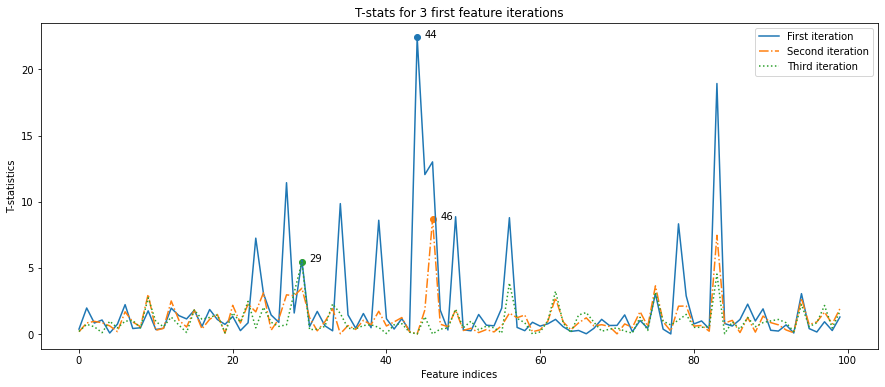

In [492]:
# Plots each iteration's graph
plt.figure(figsize=(15, 6))
plt.xlabel('Feature indices')
plt.ylabel('T-statistics')
plt.title('T-stats for 3 first feature iterations')
for j in range(3):
    arr = TList(A11, X_train, r11)
    i = np.where(arr == np.max(arr))[0][0]
    S11.append(i)
    A11.remove(i)
    r11 = r11 - coef(X_train[:, i], r11)*X_train[:, i]
    if j == 0:
        plt.plot(range(100), arr, color='C0', label='First iteration', ls='-')
        plt.scatter(i, arr[i], color='C0')
        plt.text(i + 1, arr[i], str(i), color='Black')
    elif j == 1:
        plt.plot(range(100), arr, color='C1', label='Second iteration', ls='-.')
        plt.scatter(i, arr[i], color='C1')
        plt.text(i + 1, arr[i], str(i), color='Black')
    else:
        plt.plot(range(100), arr, color='C2', label='Third iteration', ls=':')
        plt.scatter(i, arr[i], color='C2')
        plt.text(i+ 1, arr[i], str(i), color='Black')
plt.legend()
plt.show()


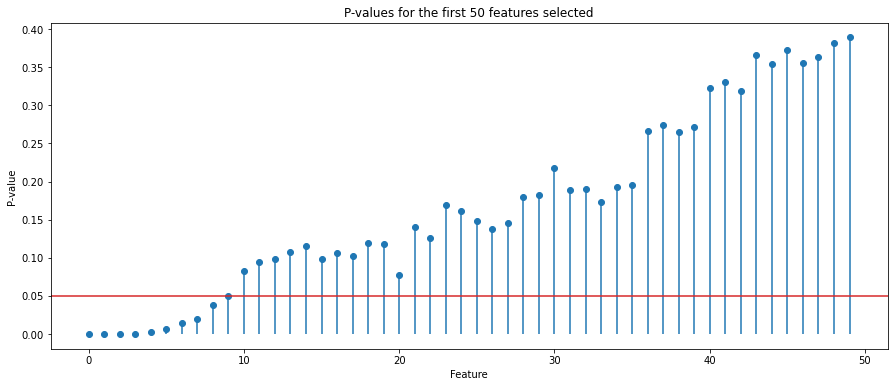

In [493]:
plt.figure(figsize=(15,6))
plt.scatter(range(50), pd.DataFrame(pval).loc[S[:50]])
plt.axhline(y=0.05, color='C3')
for i in range(50):
    plt.vlines(x=i, ymax=pd.DataFrame(pval).loc[S[i]], ymin=0)
plt.title('P-values for the first 50 features selected')
plt.xlabel('Feature')
plt.ylabel('P-value')
plt.show()


The indexes selected were:

In [494]:
sel = np.arange(100)[np.array(pval) < 0.05]
sel


array([ 9, 22, 28, 29, 33, 44, 46, 62, 75, 83])

The labels selected were:

In [495]:
X.columns[sel]


Index(['X39', 'X53', 'X17', 'X7', 'X57', 'X12', 'X10', 'X49', 'X3', 'X5'], dtype='object')

### 12.

In [496]:
fvs_reg = LinearRegression().fit(X_train[:, sel], Y_train)

fvs_coef = np.zeros(100)
fvs_coef[sel] = fvs_reg.coef_

df_coef.loc[:, 'FVS'] = fvs_coef
df_test.loc[:, 'FVS'] = np.array(fvs_reg.predict(X_test[:, sel]))


In [497]:
# Obtaining and printing R2 and MSE
dc = determination_coefficient(Y_test, np.array(df_test.loc[:, 'FVS']))
mse = mean_squared_error(Y_test, np.array(df_test.loc[:, 'FVS']))
print(f'The determination coefficient obtained was: {dc:.3f}')
print(f'The mean squared error obtained was: {mse:.3f}')


The determination coefficient obtained was: 0.555
The mean squared error obtained was: 0.445


### 13.

The OLS resulted in all coefficients being contained in $[-0.4, 0.3]$ which means that all values were relatively small, thus the penalization imposed by ridge's regularization coefficient shouldn't affect the results much. That was exactly what happened, as Ridge and OLS had similar coefficients.

The Lasso and FVS methods were supposed to equate various features to zero in order to obtain a more simplified model without losing quality. Both of them eliminated over half the features while maintaining results as good as the other models.

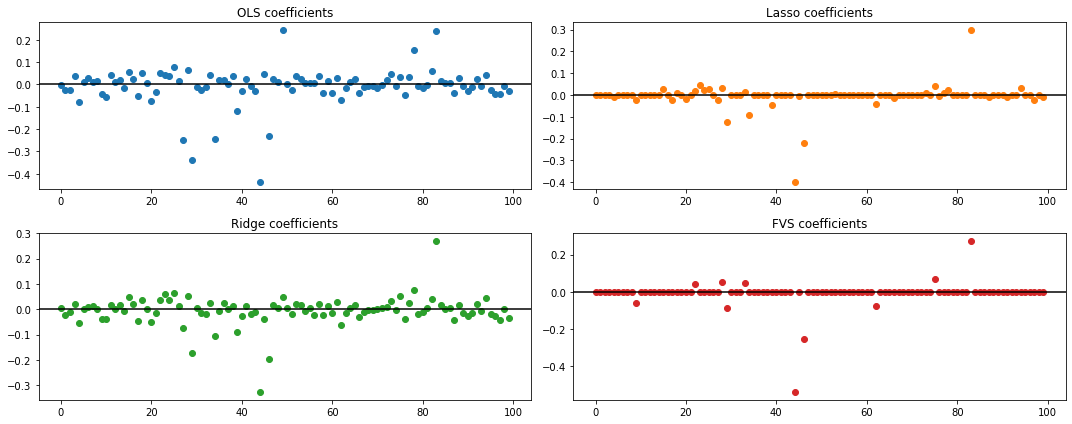

In [498]:
plt.subplots(2, 2, figsize=(15, 6))

plt.subplot(221)
plt.title('OLS coefficients')
plt.axhline(y=0, color='black')
plt.scatter(range(100), df_coef.loc[:, 'OLS'], color='C0')

plt.subplot(222)
plt.title('Lasso coefficients')
plt.axhline(y=0, color='black')
plt.scatter(range(100), df_coef.loc[:, 'lasso'], color='C1')

plt.subplot(223)
plt.title('Ridge coefficients')
plt.axhline(y=0, color='black')
plt.scatter(range(100), df_coef.loc[:, 'ridge'], color='C2')

plt.subplot(224)
plt.title('FVS coefficients')
plt.axhline(y=0, color='black')
plt.scatter(range(100), df_coef.loc[:, 'FVS'], color='C3')

plt.tight_layout()
plt.show()


### 14. 

The lasso method tries to take advantage of sparsity, its objective is to select the most relevant features and keep only them in the model in order to simplify it. While the ridge regression aims to solve a totally different problem, to stop an otherwise normal OLS model from having very large coefficients, it doesn't aim to make the model sparse. Therefore it is expected that the Lasso has many zeros and that the ridge has very few. That is exactly what happened.

In [499]:
ols = np.count_nonzero(df_coef.loc[:, 'OLS'] == 0)
lasso = np.count_nonzero(df_coef.loc[:, 'lasso'] == 0)
ridge = np.count_nonzero(df_coef.loc[:, 'ridge'] == 0)
fvs = np.count_nonzero(df_coef.loc[:, 'FVS'] == 0)


In [500]:
print(f'The amount of variables equal to zero on the OLS is: {ols}')
print(f'The amount of variables equal to zero on the lasso is: {lasso}')
print(f'The amount of variables equal to zero on the ridge is: {ridge}')
print(f'The amount of variables equal to zero on the FVS is: {fvs}')


The amount of variables equal to zero on the OLS is: 0
The amount of variables equal to zero on the lasso is: 63
The amount of variables equal to zero on the ridge is: 0
The amount of variables equal to zero on the FVS is: 90


### 15. 
Given the regression results for centered variables we have, for a new dataset X:
$$Y = X\widehat{\theta}^{rd}$$

$$Y = X\widehat{\theta}^{ols}$$

Considering $U_k$ is the singular vector matrix associated to the k largest singular vectors:

$$Y = XU_K\widehat{\theta}^{pca}$$

$$Y = X\widehat{\theta}^{ls}$$

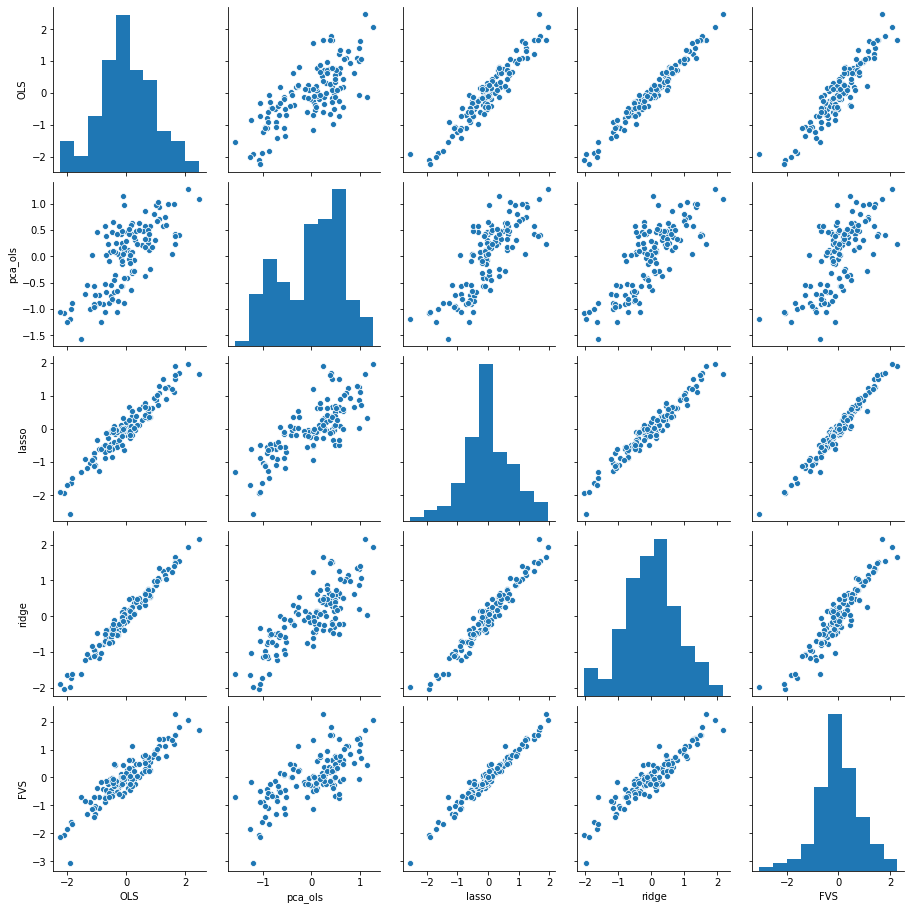

In [501]:
sn.pairplot(df_test)
plt.show()
